<IPython.core.display.Javascript object>


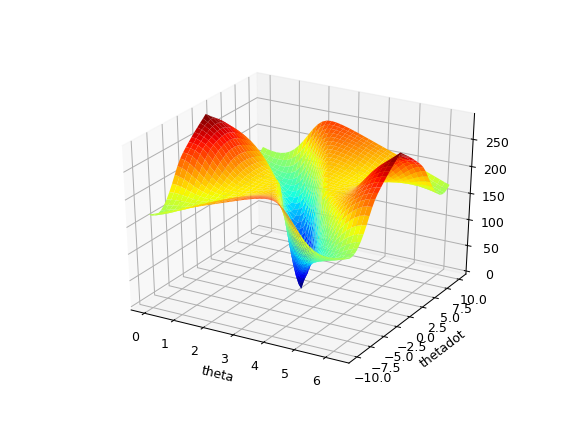

<IPython.core.display.Javascript object>


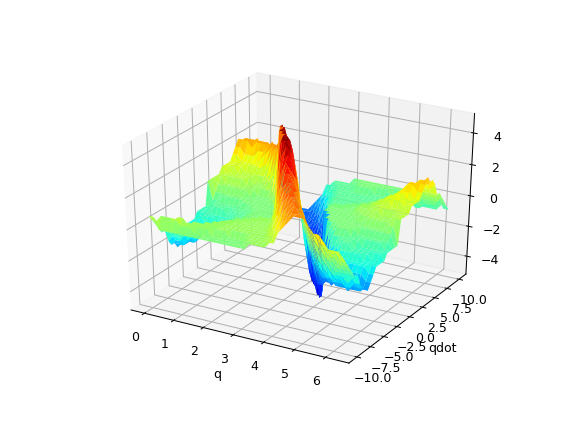

In [330]:
# %matplotlib inline
%matplotlib notebook
from __future__ import print_function, absolute_import

import math
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

from pydrake.all import (DiagramBuilder, SignalLogger, Simulator, VectorSystem)
from pydrake.examples.pendulum import PendulumPlant
from pydrake.systems.controllers import (
    DynamicProgrammingOptions, FittedValueIteration, PeriodicBoundaryCondition)
from visualizer import PendulumVisualizer


expmt = "pendulum"
expmt = "double_integrator"


plant = PendulumPlant()
simulator = Simulator(plant)
options = DynamicProgrammingOptions()


def min_time_cost(context):
    x = context.get_continuous_state_vector().CopyToVector()
    x[0] = x[0] - math.pi
    if x.dot(x) < .05:
        return 0.
    return 1.


def quadratic_regulator_cost(context):
    x = context.get_continuous_state_vector().CopyToVector()
    x[0] = x[0] - math.pi
    u = plant.EvalVectorInput(context, 0).CopyToVector()
    return 2*x.dot(x) + 25*u.dot(u)


if (False):
    cost_function = min_time_cost
    input_limit = 1.
    options.convergence_tol = 0.001
else:
    cost_function = quadratic_regulator_cost
    input_limit = 5.
    options.convergence_tol = 0.001

# qbins = np.hstack((np.linspace(0., math.pi-0.2, 5), np.linspace(math.pi-0.1, math.pi+0.1, 5), np.linspace(math.pi+0.2, 2*math.pi, 5)))
# qbins = np.linspace(0., math.pi*2, 23)
# qdotbins = np.hstack((np.linspace(-10., 10., 21)))
qbins = np.linspace(0., math.pi*2, 41)
qdotbins = np.hstack((np.linspace(-10., 10., 41)))
state_grid = [set(qbins), set(qdotbins)]
options.periodic_boundary_conditions = [
    PeriodicBoundaryCondition(0, 0., 2.*math.pi),
]
input_grid = [set(np.linspace(-input_limit, input_limit, 27))]
timestep = 0.001

[Q, Qdot] = np.meshgrid(qbins, qdotbins)
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel("theta")
ax.set_ylabel("thetadot")

fig2 = plt.figure()
ax2 = fig2.gca(projection='3d')
ax2.set_xlabel("q")
ax2.set_ylabel("qdot")


def draw(iteration, mesh, cost_to_go, policy):
    # Drawing is slow, don't draw every frame.
    if iteration % 10 != 0:
        return
    plt.title("iteration " + str(iteration))
    J = np.reshape(cost_to_go, Q.shape)
    surf = ax.plot_surface(Q, Qdot, J, rstride=1, cstride=1,
                           cmap=cm.jet)

    Pi = np.reshape(policy, Q.shape)
    surf2 = ax2.plot_surface(Q, Qdot, Pi, rstride=1, cstride=1, cmap=cm.jet)

#     if plt.get_backend() != u'template':
    plt.draw_all()
    plt.pause(0.00001)

#     surf.remove()
#     surf2.remove()


# options.visualization_callback = draw

policy, cost_to_go = FittedValueIteration(simulator, cost_function,
                                          state_grid, input_grid,
                                          timestep, options)

J = np.reshape(cost_to_go, Q.shape)
surf = ax.plot_surface(Q, Qdot, J, rstride=1, cstride=1,
                       cmap=cm.jet)
Pi = np.reshape(policy.get_output_values(), Q.shape)
surf = ax2.plot_surface(Q, Qdot, Pi, rstride=1, cstride=1,
                        cmap=cm.jet)


In [331]:
from pydrake.all import (BarycentricMesh, BarycentricMeshSystem)
experiment="pendulum"
def save_policy(name): # binds to policy and state_grid
    output_values = policy.get_output_values()
    np.save('numpy_saves/pi_b_mesh_init__'+experiment+'_'+name, state_grid)
    np.save('numpy_saves/pi_output_values__'+experiment+'_'+name, output_values)
def load_policy(name):
    b_mesh_init = np.load('numpy_saves/pi_b_mesh_init__'+experiment+'_'+name+'.npy').tolist()
    output_values = np.load('numpy_saves/pi_output_values__'+experiment+'_'+name+'.npy')
    b_mesh = BarycentricMesh(b_mesh_init)
    return BarycentricMeshSystem(b_mesh, output_values)
save_policy('good')
# test = load_policy('good')

## OK, let's try to fit with supervised learning

## Visualize the resultant super overfit thing

In [8]:
Pi = np.reshape(policy.get_output_values(), Q.shape)
surf = ax2.plot_surface(Q, Qdot, Pi, rstride=1, cstride=1,
                        cmap=cm.jet)

In [324]:
# Animate the resulting policy.
builder = DiagramBuilder()
pendulum = builder.AddSystem(PendulumPlant())


# TODO(russt): add wrap-around logic to barycentric mesh
# (so the policy has it, too)
class WrapTheta(VectorSystem):
    def __init__(self):
        VectorSystem.__init__(self, 2, 2)

    def _DoCalcVectorOutput(self, context, input, state, output):
        output[:] = input
        twoPI = 2.*math.pi
        output[0] = output[0] - twoPI * math.floor(output[0] / twoPI)


wrap = builder.AddSystem(WrapTheta())
builder.Connect(pendulum.get_output_port(0), wrap.get_input_port(0))
vi_policy = builder.AddSystem(policy)
builder.Connect(wrap.get_output_port(0), vi_policy.get_input_port(0))
builder.Connect(vi_policy.get_output_port(0), pendulum.get_input_port(0))
# Also log u's
logger_u = builder.AddSystem(SignalLogger(1))
# plot_trajectory(logger_u.data(), "tip_quiver", "pendulum", create_figure=False, symbol='-')))
logger_u._DeclarePeriodicPublish(0.01, 0.0)
builder.Connect(vi_policy.get_output_port(0), logger_u.get_input_port(0))

logger = builder.AddSystem(SignalLogger(2))
logger._DeclarePeriodicPublish(0.01, 0.0)
builder.Connect(pendulum.get_output_port(0), logger.get_input_port(0))

diagram = builder.Build()
simulator = Simulator(diagram)
simulator.set_publish_every_time_step(False)

state = simulator.get_mutable_context().get_mutable_continuous_state_vector()
# state.SetFromVector([0, 1.5])

ic = (4.9234397052604955, -8.284049094785054)
state.SetFromVector(ic)

In [325]:
simulator.StepTo(0.01*(300-2))

<IPython.core.display.Javascript object>


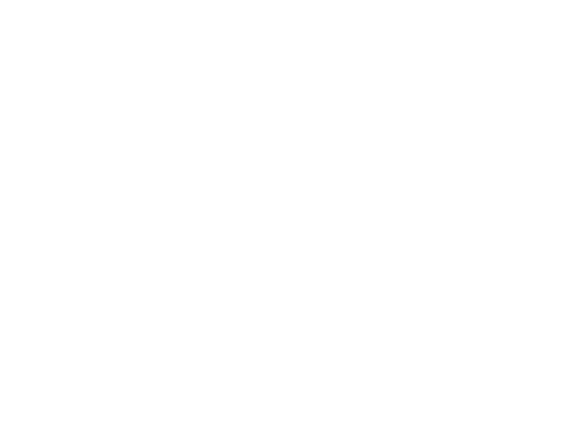

In [326]:
# Visualize the result as a video.
vis = PendulumVisualizer()
ani = vis.animate(logger, repeat=True)

# plt.show()
# Things added to get visualizations in an ipynb
plt.close(vis.fig)
HTML(ani.to_html5_video())

## Let's verify the cost to go against cost of many random (w/ random inits) dircols!

In [329]:
from pydrake.all import (
    DirectCollocation, 
    PiecewisePolynomial, 
    SolutionResult,
)
from traj.vi_utils import do_dircol_pendulum


def do_dircol(ic=(-1., 0.), warm_start="linear", seed=1776, should_vis=False):
    do_dircol_pendulum(ic           = ic, 
                       warm_start   = warm_start, 
                       seed         = seed, 
                       should_vis   = should_vis
                       num_samples  = 300, 
                       min_timestep = 0.01, 
                       max_timestep = 0.01)


ic = (4.9234397052604955, -8.284049094785054)
dircol, result = do_dircol(ic=ic, warm_start="linear", should_vis=False)
sum_cost        = np.sum(np.abs([dircol.EvalBindingAtSolution(cost) for cost in dircol.GetAllCosts()]))
sum_constraints = np.sum([np.sum(np.abs(dircol.EvalBindingAtSolution(constraint))) for constraint in dircol.GetAllConstraints()])
found_value     = sum_cost + sum_constraints

# print(found_value)
nearest_xdot  = int(J.shape[0] * (ic[1] - -10)/(20))
nearest_x     = int(J.shape[1] * (ic[0] - 0)/(2*math.pi))
expected_value  = J[nearest_xdot][nearest_x]
print("ic={}, found_value= {:.2f} + {:.2f} = {:.2f}, expected_value= {:.2f}".format(ic, sum_cost, sum_constraints, found_value, expected_value))
# for t in np.linspace(dircol.GetSampleTimes)
# print(dircol.ReconstructInputTrajectory(), dircol.ReconstructStateTrajectory())



# def eval_policy(x):
#     mesh = policy.get_mesh()
#     ovs  = policy.get_output_values()
#     return mesh.Eval(ovs, x)

# # On-knot
# times   = dircol.GetSampleTimes().T
# x_knots = dircol.GetStateSamples().T
# u_knots = dircol.GetInputSamples().T
# for t, x, u in zip(times, x_knots, u_knots):
#     expected_u = eval_policy(x)
#     found_u    = u
#     print("On-knot: {} vs {}".format(expected_u, found_u))

# # Off-knot
# x_trajectory   = dircol.ReconstructStateTrajectory()
# u_trajectory   = dircol.ReconstructInputTrajectory()
# for t in np.linspace(times[0], times[-1], 100): # Pick uniform 100 times along the trajectory!
#     x = x_trajectory.value(t)
#     u = u_trajectory.value(t)
#     expected_u = eval_policy(x)
#     found_u    = u[0] # To go from shape (1, 1) -> (1,)
#     print("Off-knot: {} vs {}".format(expected_u, found_u))

# Below is an investigation...
from traj.vis import (plot_trajectory)
dircol.ReconstructStateTrajectory()
# t_samples = dircol.GetSampleTimes()
# x_samples = np.hstack([x_trajectory.value(t) for t in t_samples])

# WOW - insane agreement between traj opt and the policy... (for states...)
if False:
    plot_trajectory(dircol.GetStateSamples(), "tip_quiver", "pendulum", create_figure=True, symbol='-')
    plot_trajectory(logger.data(), "tip_quiver", "pendulum", create_figure=False, symbol='-')

# Let's check the agreement for the input u's
N = 300
if False:
    plt.figure()
    plt.plot(list(range(N)), dircol.GetInputSamples()[0], label="traj")
    plt.plot(list(range(N)), logger_u.data()[0], label="sim")
    plt.legend()
    plt.show()

# Ok, so will we see this same divergence if we plot x and x_dot versus time together?
if False:
    plt.figure()
    plt.plot(list(range(N)), dircol.GetStateSamples()[0], label="traj")
    plt.plot(list(range(N)), logger.data()[0], label="sim")
    plt.legend()
    plt.figure()
    plt.plot(list(range(N)), dircol.GetStateSamples()[1], label="traj")
    plt.plot(list(range(N)), logger.data()[1], label="sim")
    plt.legend()
    plt.show()

# Ok, now let's manually calculate the costs and constraints
import copy
def cost(x, u):
    x = copy.deepcopy(x)
    u = copy.deepcopy(u)
    x[0] = x[0] - math.pi
    return 2*x.dot(x) + 25*u.dot(u)
traj_cost = 0
for x, u in zip(dircol.GetStateSamples().T, dircol.GetInputSamples().T):
#     print(x, u)
    traj_cost += cost(x, u) * 0.01 # For the timestep scaling!
    
sim_cost = 0
for x, u in zip(logger.data().T, logger_u.data().T):
#     print(x, u)
    sim_cost += cost(x, u) * 0.01 # For the timestep scaling!
    
print("traj_cost={} sim_cost={}".format(traj_cost, sim_cost))


ic=(4.9234397052604955, -8.284049094785054), found_value= 27.42 + 109.05 = 136.47, expected_value= 143.58
traj_cost=28.5919398965 sim_cost=31.5360783138


0 result=SolutionResult.kInfeasibleConstraints
ic=(0.9068301661293942, -5.763955078865147), found_value=278.091760475, expected_value=266.484707823
ic=(3.1934398280249514, -3.4032563259734827), found_value=265.448368947, expected_value=235.472054398
ic=(3.3242775040561057, -3.3563158703572853), found_value=186.57281935, expected_value=177.786981316
ic=(1.5554418252223539, 3.5603481435555935), found_value=227.810679957, expected_value=243.036919724
ic=(3.204989718852526, -0.16709657963027702), found_value=14.26480136, expected_value=2.79083261501e-12
ic=(0.7972823963329138, 6.990847611716369), found_value=116.420506055, expected_value=237.475112219
result=SolutionResult.kInfeasibleConstraints
result=SolutionResult.kInfeasibleConstraints
result=SolutionResult.kInfeasibleConstraints
result=SolutionResult.kInfeasibleConstraints
ic=(5.593617158561769, -6.210767566993396), found_value=184.756736771, expected_value=237.47511247
result=SolutionResult.kInfeasibleConstraints
ic=(4.94465453459008

result=SolutionResult.kInfeasibleConstraints
ic=(4.8497019642595784, -9.712981803573118), found_value=206.739017229, expected_value=255.345609785
ic=(1.246399548361678, 4.125107820828584), found_value=258.606288422, expected_value=269.772813289
result=SolutionResult.kInfeasibleConstraints
ic=(3.7328888948626484, 0.24607137029205717), found_value=227.846502721, expected_value=185.754765129
result=SolutionResult.kInfeasibleConstraints
ic=(1.1401979600670968, -4.98167270229928), found_value=283.088321779, expected_value=271.076783027
ic=(1.3102906340451992, -8.592150110063894), found_value=295.536804835, expected_value=251.078655378
150 ic=(5.887777776111207, 8.781181962373871), found_value=265.497897685, expected_value=234.860092512
result=SolutionResult.kInfeasibleConstraints
result=SolutionResult.kInfeasibleConstraints
result=SolutionResult.kInfeasibleConstraints
ic=(0.24256789170728363, -8.679649842764283), found_value=254.551998897, expected_value=229.03094142
result=SolutionResult.k

ic=(1.1226101578952186, -2.839635984874757), found_value=317.245505041, expected_value=289.505571633
ic=(1.6580298184817992, 4.81128399752998), found_value=97.910294541, expected_value=187.66421747
ic=(1.7867906719509696, 3.9009843749865993), found_value=129.025999948, expected_value=207.635805736
ic=(2.1502662473606367, 7.413291452022147), found_value=243.828868614, expected_value=237.715677279
result=SolutionResult.kInfeasibleConstraints
ic=(1.421249285429775, 9.7983016351705), found_value=207.884426006, expected_value=255.345607474
ic=(0.6390081540445666, -6.239590907293742), found_value=275.304952924, expected_value=257.052612147
ic=(0.36924700224861745, 6.3588577013626235), found_value=321.370029812, expected_value=248.59027378
result=SolutionResult.kInfeasibleConstraints
result=SolutionResult.kInfeasibleConstraints
result=SolutionResult.kInfeasibleConstraints
result=SolutionResult.kInfeasibleConstraints
ic=(0.6050296575351864, -8.769262974906306), found_value=266.546931386, expec

result=SolutionResult.kInfeasibleConstraints
ic=(3.930782246534274, -6.73781980317155), found_value=270.229608301, expected_value=232.59436688
ic=(0.34428945587005083, 7.135973011155503), found_value=318.025977364, expected_value=248.59027378
result=SolutionResult.kInfeasibleConstraints
ic=(5.811590967616564, 8.575001648797102), found_value=264.907633045, expected_value=234.860092512
ic=(5.021088081931142, -4.41616023982559), found_value=231.095393234, expected_value=245.136827567
ic=(2.7156058289757077, 3.6502398653464585), found_value=111.300782009, expected_value=141.464529009
450 ic=(1.0448815541100391, -3.170512385242046), found_value=318.186359807, expected_value=302.747819534
ic=(4.964452805323657, 4.934324056149455), found_value=280.639701155, expected_value=271.076783005
ic=(4.7224665816563025, -2.9280910065547943), found_value=297.829957392, expected_value=268.42987869
result=SolutionResult.kInfeasibleConstraints
result=SolutionResult.kInfeasibleConstraints
ic=(5.457882137567

<IPython.core.display.Javascript object>


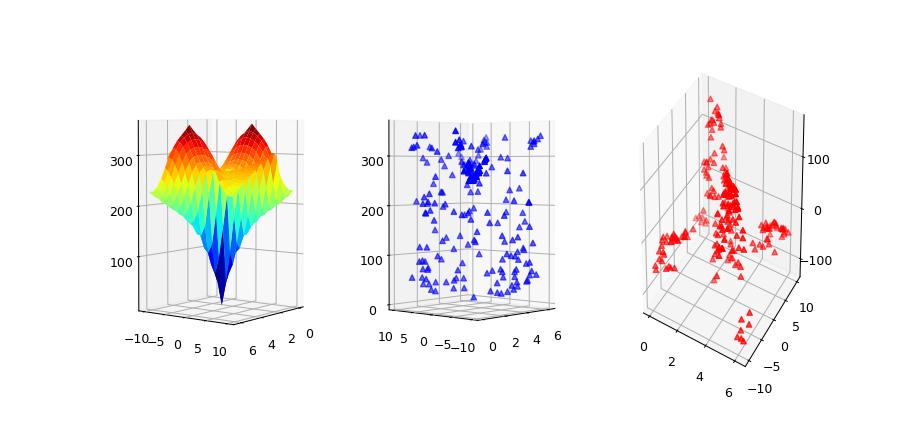

In [262]:
%matplotlib notebook
# Gen a bunch of random initial conditions
n = 500
xs = np.random.uniform(0, 2*math.pi, n)
x_dots = np.random.uniform(-10, 10, n)
ics = zip(xs, x_dots)
# ics = [(4.9234397052604955, -8.284049094785054)]
# print(J.shape)

# Do dircol from them
good_ics = [] # TODO: remove?
J = np.reshape(cost_to_go, Q.shape)
found_values, expected_values = [], []
SSE = 0
for i, ic in enumerate(ics):
    # TODO: turn on the random initializations!!
    if i % 50 == 0:
        print("{} ".format(i), end='')
    dircol, result  = do_dircol(ic=ic, warm_start="linear", seed=1776, should_vis=False)
    sum_cost        = np.sum(np.abs([dircol.EvalBindingAtSolution(cost) for cost in dircol.GetAllCosts()]))
    sum_constraints = np.sum([np.sum(np.abs(dircol.EvalBindingAtSolution(constraint))) for constraint in dircol.GetAllConstraints()])
    found_value     = sum_cost + sum_constraints
    if found_value > 350.:
        continue
    else:
        good_ics.append(ic)
    found_values.append(found_value)
    
    # TODO: Expected value might need to rely on barycentric interpolation? consider using BarycentricMeshSystem
    # Do it via the distance between the lower bound and the upper bound, rounded to to the nearest bin?
    nearest_xdot  = int(J.shape[0] * (ic[1] - -10)/(20))
    nearest_x     = int(J.shape[1] * (ic[0] - 0)/(2*math.pi))
    expected_value  = J[nearest_xdot][nearest_x]
    expected_values.append(expected_value)
    SSE += (expected_value - found_value)**2
    print("ic={}, found_value={}, expected_value={}".format(ic, found_value, expected_value))
MSE = SSE / n
print("MSE: {}".format(MSE))
    
# Plot expected vs actual, in a 3d graph, since we have a 2d state space...
# Here's the reference graph, in all of it's glory...
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(131, projection='3d')
J = np.reshape(cost_to_go, Q.shape)
surf = ax.plot_surface(Q, Qdot, J, rstride=1, cstride=1,
                       cmap=cm.jet)

# 3d scatter for the actuals?
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure()
ax = fig.add_subplot(132, projection='3d')
xs, ys = zip(*good_ics)
zs = found_values
ax.scatter(xs, ys, zs, c='b', marker='^')

# Plot the residuals here!
ax = fig.add_subplot(133, projection='3d')
xs, ys = zip(*good_ics)
zs = np.array(expected_values) - np.array(found_values)
ax.scatter(xs, ys, zs, c='r', marker='^')

## Let's evaluate the policy against (u, x) of many random (w/ random inits) dircols!

knot_MSE: [17.83231951], traj_MSE: [120.70601857]
[(1600, 2), (1600, 1), (1600, 1)]


<IPython.core.display.Javascript object>


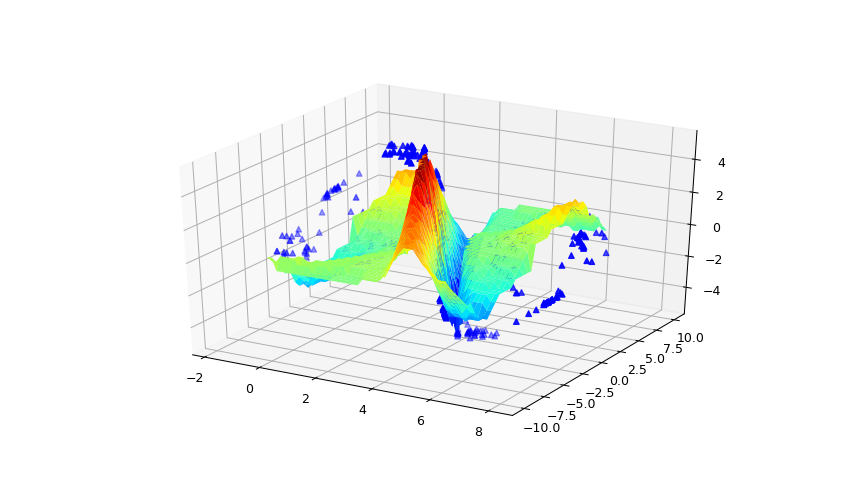

In [346]:
# Gen a bunch of random initial conditions
n=100
xs = np.random.uniform(0, 2*math.pi, n)
x_dots = np.random.uniform(-2, 2, n)
ics = zip(xs, x_dots)

from traj.vi_utils import (graph_vi_policy_vs_traj_knot_scatter)

graph_vi_policy_vs_traj_knot_scatter(policy, ics, 
                                     combine_vi_policy_and_scatter=True,
                                     plot_residual=False)

## Let's see what nets we can fit to this policy!

[1,  1000] loss: 15.715
[2,  1000] loss: 4.762
[3,  1000] loss: 3.864
[4,  1000] loss: 4.097
[5,  1000] loss: 3.506
[6,  1000] loss: 2.446
[7,  1000] loss: 1.733
[8,  1000] loss: 1.411
[9,  1000] loss: 1.360
[10,  1000] loss: 1.098
[11,  1000] loss: 1.041
[12,  1000] loss: 1.092
[13,  1000] loss: 1.077
[14,  1000] loss: 1.076
[15,  1000] loss: 1.033
[16,  1000] loss: 1.082
[17,  1000] loss: 0.967
[18,  1000] loss: 0.881
[19,  1000] loss: 0.925
[20,  1000] loss: 0.904
[21,  1000] loss: 1.003
[22,  1000] loss: 0.840
[23,  1000] loss: 1.086
[24,  1000] loss: 0.736
[25,  1000] loss: 0.852
[26,  1000] loss: 0.852
[27,  1000] loss: 0.782
[28,  1000] loss: 0.818
[29,  1000] loss: 0.781
[30,  1000] loss: 0.721
[31,  1000] loss: 0.698
[32,  1000] loss: 0.709
[33,  1000] loss: 0.672
[34,  1000] loss: 0.626
[35,  1000] loss: 0.613
[36,  1000] loss: 0.787
[37,  1000] loss: 0.701
[38,  1000] loss: 0.640
[39,  1000] loss: 0.696
[40,  1000] loss: 0.644
[41,  1000] loss: 0.728
[42,  1000] loss: 0.649


<IPython.core.display.Javascript object>


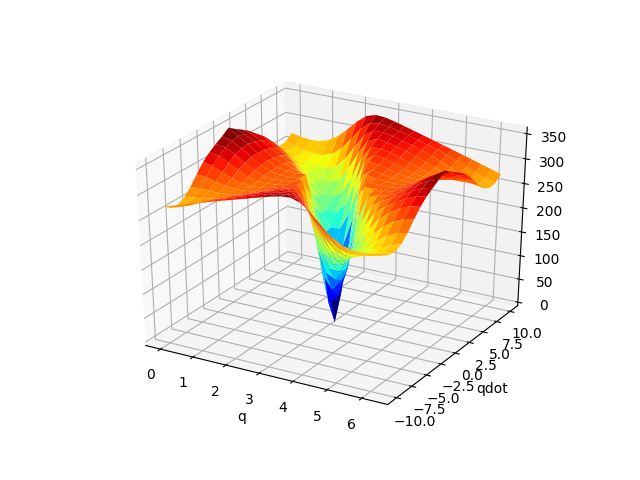

<IPython.core.display.Javascript object>


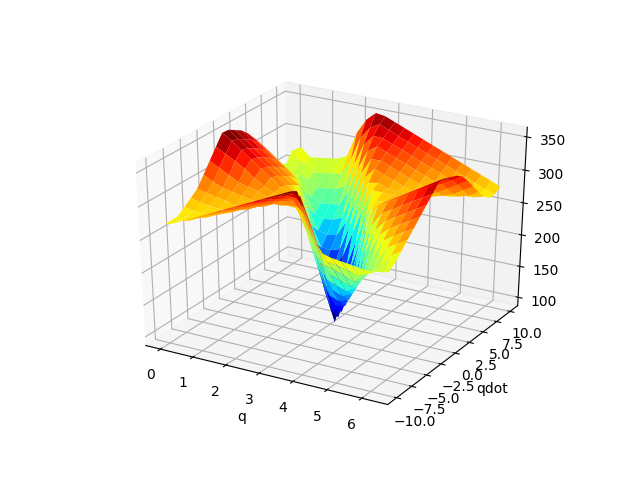

In [119]:
# SUPER OVERFITTING + L2 + parameter distance metric!
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from nn_system.NNSystemHelper import FC, MLPSMALL#, MLP
# from nn_system.NNSystemHelper import FC, FCBIG, MLPSMALL#, MLP

class FCBIG(nn.Module):
    def __init__(self, n_inputs=4, h_sz=8):
        super(FCBIG, self).__init__()
        self.n_inputs = n_inputs
        self.fc2 = nn.Linear(self.n_inputs, h_sz)
        self.fc3 = nn.Linear(h_sz, 1)

    def forward(self, x):
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    
class MLP(nn.Module):
    def __init__(self, n_inputs=4, h_sz=256, layer_norm=False):
        super(MLP, self).__init__()
        self.n_inputs = n_inputs
        self.layer_norm = layer_norm

        self.l1 = nn.Linear(self.n_inputs, h_sz)
        self.ln1 = nn.LayerNorm(h_sz)
        self.tanh1 = torch.tanh
        self.l2 = nn.Linear(h_sz, h_sz)
        self.ln2 = nn.LayerNorm(h_sz)
        self.tanh2 = torch.tanh
        self.l3 = nn.Linear(h_sz, 1)
    
    def forward(self, x):
        x = self.l1(x)
        if self.layer_norm: x = self.ln1(x)
        x = self.tanh1(x)
        x = self.l2(x)
        if self.layer_norm: x = self.ln2(x)
        x = self.tanh2(x)
        x = self.l3(x)
        return x

net = FCBIG(2, 32)
# net = MLPSMALL(2)
# net = MLP(2, 16)

criterion = nn.MSELoss()
# optimizer = optim.SGD(net.parameters(), lr=1e-5, momentum=0.3)
optimizer = optim.Adam(net.parameters(), 6e-4)
# optimizer = optim.Adam(net.parameters(), 1e-3)
# optimizer = optim.Adam(net.parameters(), lr=1e-2) # For policy!

EPOCHS = 100

# My data
coords = zip(Q.flatten(), Qdot.flatten())
# cost_to_go
# policy.get_output_values()[0]

def my_gen():
    for _ in range(1000):
        idxs = np.random.uniform(0, np.prod(cost_to_go.shape), 483).astype(np.int)
        inputs = np.array(coords)[idxs]
        labels = np.array(cost_to_go).reshape(-1, 1)[idxs]
#     labels = policy.get_output_values()[0]

#         inputs = np.array(coords)
#         labels = cost_to_go.reshape(-1, 1)
#         print(inputs.shape, labels.shape)
#         labels = policy.get_output_values()[0].reshape(-1, 1)
        yield inputs, labels
    
for epoch in range(EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(my_gen(), 0):
        # Unpack data
        inputs, labels = data
        inputs = torch.tensor(inputs)
        labels = torch.tensor(labels)

        # Forward pass
        outputs = net(inputs)
#         print(outputs.size())
        loss = criterion(outputs, labels)
#         print(loss.size())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i+1) % 1000 == 0:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
        running_loss = 0.0

print('Finished Training')


fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel("q")
ax.set_ylabel("qdot")

fig2 = plt.figure()
ax2 = fig2.gca(projection='3d')
ax2.set_xlabel("q")
ax2.set_ylabel("qdot")

J = np.reshape(cost_to_go, Q.shape)
surf = ax.plot_surface(Q, Qdot, J, rstride=1, cstride=1,
                       cmap=cm.jet)
J_pred = np.reshape(net.forward(torch.tensor(coords)).data.numpy(), Q.shape)
surf = ax2.plot_surface(Q, Qdot, J_pred, rstride=1, cstride=1,
                       cmap=cm.jet)

# Pi = np.reshape(policy.get_output_values(), Q.shape)
# surf = ax.plot_surface(Q, Qdot, Pi, rstride=1, cstride=1,
#                         cmap=cm.jet)
# Pi_pred = np.reshape(net.forward(torch.tensor(coords)).data.numpy(), Q.shape)
# surf = ax2.plot_surface(Q, Qdot, Pi_pred, rstride=1, cstride=1,
#                        cmap=cm.jet)

## Can a net fit to this policy when it only get's stochastic samples of the known optimal policy

## Can traj opt inited with the above fitted optimal policy stay in place / find the optimal off of a small perturbation?